# Data exploration + preprocess

In [17]:
import data
from data_prepro import na_month_plot_bypermno

import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

df = data.load_process()


Loading stock parquet
Loading VIX parquet.


In [2]:
#Permnos
print("Shape:",df.shape)
print("Unique permnos:", len(df['permno'].unique()))

Shape: (2646081, 25)
Unique permnos: 1063


# Missing values

Dropping missing tickers

In [3]:
# Drop missing tikcer since they are nearing mbrenddt
df_pro = df.dropna(subset = ['ticker'])

## Investigating missing `vol` 

In [4]:
df_pro[df_pro['vol'].isna()]

,permno,ticker,vol,ret,shrout,prc,ask,bid,gsector,mktrf,...,rf,mbrstartdt,mbrenddt,put_volume,call_volume,put_call_ratio,gsector_name,Enhanced Investor Sentiment Index (STV),vix_close,News Sentiment
2002-05-23,11983,BGEN,<NA>,<NA>,148521.0,<NA>,<NA>,<NA>,35,0.0105,...,0.00007,2000-01-31,2003-11-12,0.0,0.0,<NA>,Health Care,-2.589,18.23,-0.07
2003-01-13,10324,GENZ,<NA>,<NA>,215119.0,<NA>,<NA>,<NA>,35,-0.0012,...,0.00005,2001-12-14,2011-04-01,0.0,0.0,<NA>,Health Care,-3.890,24.90,-0.04
2005-10-24,10562,SOV,<NA>,<NA>,361670.0,<NA>,<NA>,<NA>,40,0.017,...,0.00013,2004-07-01,2009-01-29,<NA>,<NA>,<NA>,Financials,-0.979,14.74,0.13
2006-03-07,76841,BIIB,<NA>,<NA>,344099.0,<NA>,<NA>,<NA>,35,-0.004,...,0.00016,2003-11-13,2024-12-31,0.0,0.0,<NA>,Health Care,-1.529,12.66,0.30
2006-03-08,76841,BIIB,<NA>,<NA>,344099.0,<NA>,<NA>,<NA>,35,0.0014,...,0.00016,2003-11-13,2024-12-31,<NA>,<NA>,<NA>,Health Care,-1.529,12.32,0.30
2009-08-05,70519,C,<NA>,0.101538,5507700.0,3.58,3.57,3.56,40,-0.003,...,0.00001,1988-05-26,2024-12-31,643524.0,1269237.0,0.507016,Financials,3.154,24.90,-0.25
2009-12-17,70519,C,<NA>,-0.072464,22863947.0,3.2,3.22,3.21,40,-0.0118,...,0.0,1988-05-26,2024-12-31,775820.0,1305852.0,0.59411,Financials,1.434,22.51,0.03
2009-12-18,70519,C,<NA>,0.0625,22863947.0,3.4,3.35,3.34,40,0.0068,...,0.0,1988-05-26,2024-12-31,259969.0,599633.0,0.433547,Financials,1.434,21.68,0.04
2010-12-07,70519,C,<NA>,0.038202,29049600.0,4.62,4.62,4.61,40,0.001,...,0.00001,1988-05-26,2024-12-31,492030.0,2543185.0,0.19347,Financials,-0.917,17.99,-0.12
2015-05-12,76744,VRTX,<NA>,<NA>,243752.0,<NA>,<NA>,<NA>,35,-0.0027,...,0.0,2013-09-23,2024-12-31,<NA>,<NA>,<NA>,Health Care,-1.556,13.86,0.13


In [13]:
def na_month_plot_bypermno(permno: int, year: int, month: int, df: pd.DataFrame):
    # Filter the DataFrame
    mask = (
        (df.index.year == year) &
        (df.index.month == month) &
        (df['permno'] == permno)
    )
    filtered_df = df.loc[mask]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(filtered_df.index, filtered_df['vol'], marker='o', linestyle='-', label='Volume')

    # Highlight missing vol
    missing_vol = filtered_df[filtered_df['vol'].isna()]
    if not missing_vol.empty:
        ax.plot(missing_vol.index, [0] * len(missing_vol), 'rx', markersize=10, label='Missing Volume')

    # Formatting
    month_name = pd.Timestamp(year=year, month=month, day=1).strftime("%B %Y")
    ax.set_title(f'Volume for PERMNO {permno} in {month_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


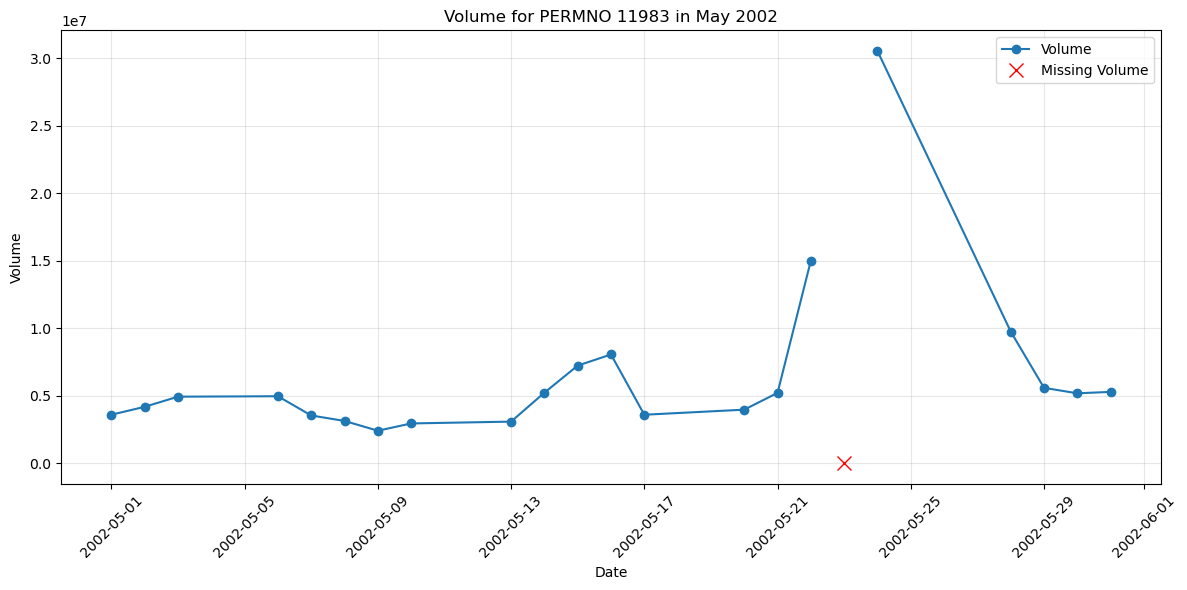

In [14]:
na_month_plot_bypermno(11983,2002,5,df_pro)

Probably good to take the mean between the dates before and after